*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation du projet](#Présentation)




* [Partie 1 🛠 Nettoyage des donnéés ](#Partie_1)


* [1.1 Représentation graphique des valeurs nulles](#Par_1)
* [1.2 Gestion des outliers (IQR & Filtres)](#Par_4)
* [1.3 Données manquantes & imputations ](#Par_5)
******

* [Partie 2 🛠 Machine Learning ](#Partie_2)

* [2.1 Régression lineaire](#Par_1)
    * [2.1.1 Régression RIDGE](#Section_5.1)
    * [2.1.2 LASSO ](#Section_5.2)

******

* [Partie 3 🛠 Comparaison des modèles](#Partie_2)
* [3.1  Matrice de confusion](#Par_4)
* [3.2 AIC & BIC](#Par_4)


[Conclusion et Recommandations](#conclusion)

[Références](#Références)

In [1145]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 set
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Construction de modèle de machine learning</div>
<a class="anchor" id="Partie_2"></a>

****

In [1146]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [1147]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [1148]:
target=df[["SiteEnergyUse(kBtu)"]]

## Création de fonctions

In [1149]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [1150]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [1151]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

# Régression linéare multiple

In [1152]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print(temps)

0.0


### Le modèle est il capable de produire de bonne prédiction ?

In [1153]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8568528198862808 
 R2 sur le set de test:  0.23362432337437677


In [1154]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

18793656.99547112


In [1155]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,1.271753e+06,46442,1.418657e+06,-1.469038e+05
1,2.114053e+06,37509,2.275360e+06,-1.613065e+05
2,1.119640e+06,37619,9.037565e+05,2.158838e+05
3,4.366041e+05,21128,1.512266e+05,2.853775e+05
4,2.826828e+06,40657,1.376174e+06,1.450654e+06
...,...,...,...,...
1000,7.385920e+05,28560,7.351022e+05,3.489797e+03
1001,3.532966e+06,22381,1.704228e+06,1.828739e+06
1002,3.010890e+06,128571,5.606487e+06,-2.595597e+06
1003,1.577041e+06,30545,2.807286e+06,-1.230245e+06


<Figure size 300x300 with 0 Axes>

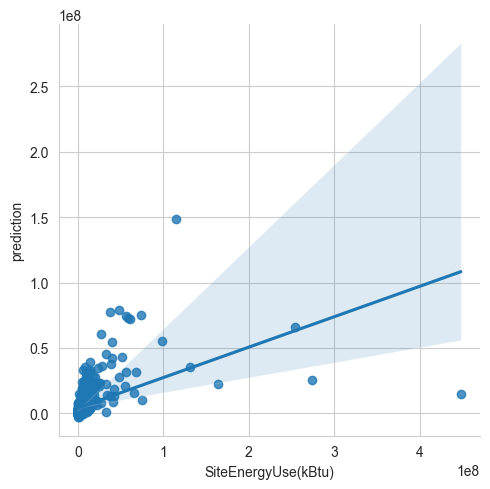

In [1156]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [1157]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
NumberofBuildings,2.516954e+06,2.516954e+06
tx_gaz,1.594880e+06,1.594880e+06
BulType,4.163044e+05,4.163044e+05
NumberofFloors,-2.872228e+05,2.872228e+05
Council,-9.638561e+04,9.638561e+04
PPT,-5.404348e+04,5.404348e+04
years,1.165615e+04,1.165615e+04
Zip,-1.109300e+04,1.109300e+04
Voisin,-9.478768e+03,9.478768e+03
ThirdLargestPropertyUseTypeGFA,-8.970096e+01,8.970096e+01


Text(0.5, 1.0, 'Coefficients de regression')

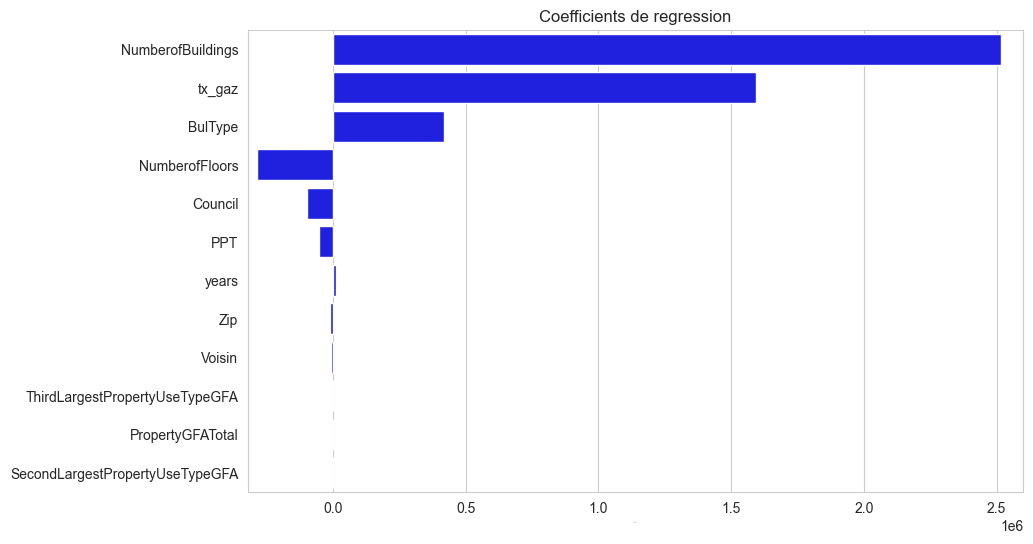

In [1158]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320_000, 2_600_000)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

# Régression linéaire sur données centrées réduites

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travailons dans cette partie sur les données centrées réduites

In [1159]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

df_cr = pd.concat([target,df_float],axis=1)
df_cr = df_cr[df_cr["SiteEnergyUse(kBtu)"]<200_000_000]

df_float = df_cr.drop(columns=["SiteEnergyUse(kBtu)"])
target = df_cr[["SiteEnergyUse(kBtu)"]]


# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["SiteEnergyUse(kBtu)"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print(temps_cr)

0.0


### Le modèle est il capable de produire de bonne prédiction ?

In [1160]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6045065132246681 
 R2 sur le set de test:  0.43460139799696573


In [1161]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8213280262531096


In [1162]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred


,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.262080,-0.335137,-0.033943,-0.228137
1,-0.378923,-0.395949,-0.311505,-0.067419
2,-0.290184,-0.116606,-0.172623,-0.117561
3,-0.326466,-0.243314,-0.107137,-0.219329
4,-0.318230,-0.222707,-0.053556,-0.264674
...,...,...,...,...
999,-0.287444,-0.465311,-0.390951,0.103508
1000,-0.340326,-0.267006,-0.131107,-0.209219
1001,0.003977,0.174117,0.090598,-0.086620
1002,-0.411427,-0.474359,-0.392787,-0.018640


<Figure size 300x300 with 0 Axes>

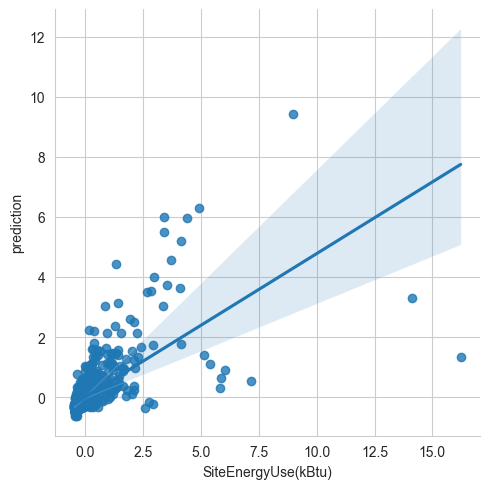

In [1163]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [1164]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.692426,0.692426
NumberofBuildings,0.137363,0.137363
SecondLargestPropertyUseTypeGFA,0.076171,0.076171
tx_gaz,0.057503,0.057503
BulType,0.044581,0.044581
ThirdLargestPropertyUseTypeGFA,-0.030759,0.030759
Zip,-0.021895,0.021895
years,0.021130,0.021130
PPT,0.011535,0.011535
NumberofFloors,-0.011114,0.011114


Text(0.5, 1.0, 'Coefficients de regression')

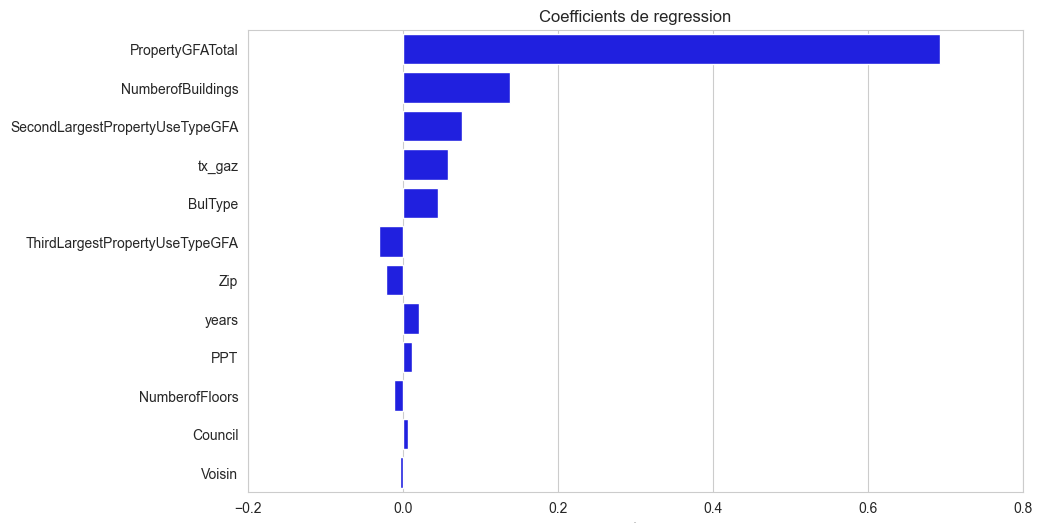

In [1165]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

# Régression Ridge

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [1181]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [1182]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print(temps_ridge)

2.149367570877075


In [1183]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [1184]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = 0.585 (+/-0.215) for {'alpha': 0.2}
mean_test_score = 0.585 (+/-0.215) for {'alpha': 0.4}
mean_test_score = 0.585 (+/-0.215) for {'alpha': 0.6}
mean_test_score = 0.585 (+/-0.215) for {'alpha': 0.8}
mean_test_score = 0.585 (+/-0.215) for {'alpha': 0.9}
mean_test_score = 0.585 (+/-0.215) for {'alpha': 2}
mean_test_score = 0.585 (+/-0.215) for {'alpha': 5}
mean_test_score = 0.585 (+/-0.216) for {'alpha': 9}
mean_test_score = 0.585 (+/-0.216) for {'alpha': 10}
mean_test_score = 0.585 (+/-0.216) for {'alpha': 11}
mean_test_score = 0.585 (+/-0.216) for {'alpha': 12}
mean_test_score = 0.587 (+/-0.218) for {'alpha': 50}
mean_test_score = 0.588 (+/-0.220) for {'alpha': 100}


In [1185]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [1243]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [1244]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.692266,0.692266
NumberofBuildings,0.137362,0.137362
SecondLargestPropertyUseTypeGFA,0.076246,0.076246
tx_gaz,0.057501,0.057501
BulType,0.044589,0.044589
ThirdLargestPropertyUseTypeGFA,-0.030732,0.030732
Zip,-0.021892,0.021892
years,0.021122,0.021122
PPT,0.011534,0.011534
NumberofFloors,-0.011060,0.011060


Text(0.5, 1.0, 'Coefficients de regression')

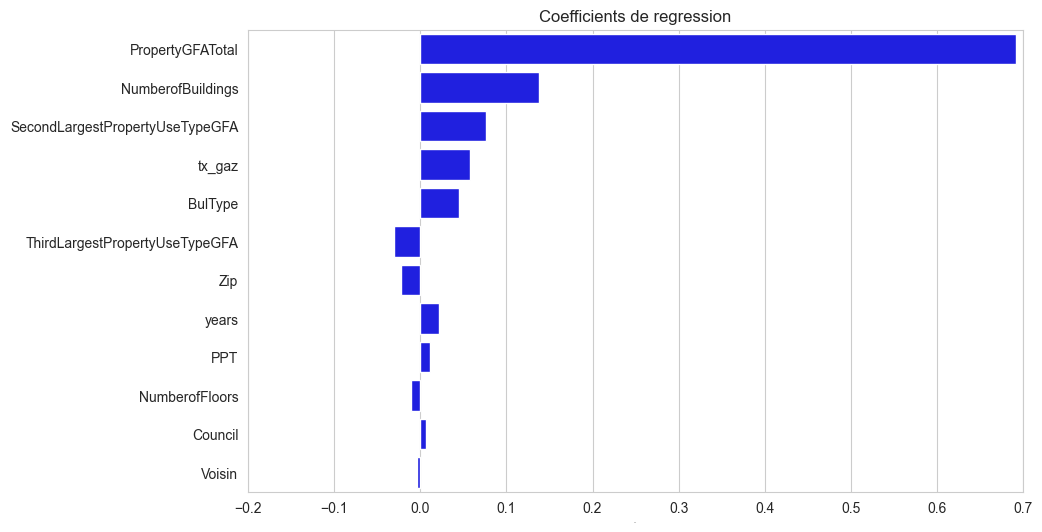

In [1245]:
# Représentation graphique des coefficients
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2,0.7)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Le modèle est il capable de produire de bonne prédiction ?

In [1191]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.602653305760865 
 R2 sur le set de test:  0.4331360361263977


In [1192]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8223916687544743


In [1193]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.262080,-0.335137,-0.033291,-0.228789
1,-0.378923,-0.395949,-0.302942,-0.075981
2,-0.290184,-0.116606,-0.151073,-0.139111
3,-0.326466,-0.243314,-0.099341,-0.227125
4,-0.318230,-0.222707,-0.065271,-0.252958
...,...,...,...,...
999,-0.287444,-0.465311,-0.370850,0.083407
1000,-0.340326,-0.267006,-0.137019,-0.203306
1001,0.003977,0.174117,0.109188,-0.105210
1002,-0.411427,-0.474359,-0.390023,-0.021404


<Figure size 300x300 with 0 Axes>

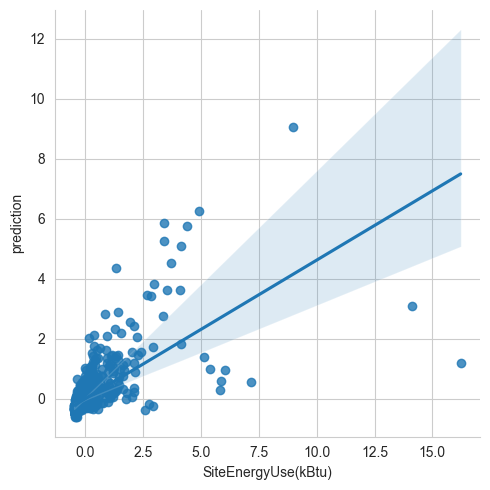

In [1194]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

# Régression Lasso

In [1195]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [1196]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print(temps_lasso)

2.781768798828125


In [1197]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [1198]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.581 (+/-0.220) pour {'alpha': 0.1}
mean_test_score = 0.555 (+/-0.242) pour {'alpha': 0.2}
mean_test_score = 0.423 (+/-0.214) pour {'alpha': 0.4}
mean_test_score = 0.187 (+/-0.096) pour {'alpha': 0.6}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 0.8}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 0.9}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 2}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 5}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 9}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 10}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 11}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 12}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 50}
mean_test_score = -0.002 (+/-0.007) pour {'alpha': 100}


In [1199]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Le modèle est il capable de produire de bonne prédiction ?

In [1206]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8269727295804473


In [1207]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.5682028244571449 
 R2 sur le set de test:  0.4268031144110025


In [1208]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [1209]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.262080,-0.335137,-0.215863,-0.046217
1,-0.378923,-0.395949,-0.254282,-0.124642
2,-0.290184,-0.116606,-0.077802,-0.212381
3,-0.326466,-0.243314,-0.157852,-0.168614
4,-0.318230,-0.222707,-0.144833,-0.173396
...,...,...,...,...
999,-0.287444,-0.465311,-0.298102,0.010659
1000,-0.340326,-0.267006,-0.172820,-0.167505
1001,0.003977,0.174117,0.105866,-0.101889
1002,-0.411427,-0.474359,-0.303819,-0.107609


<Figure size 300x300 with 0 Axes>

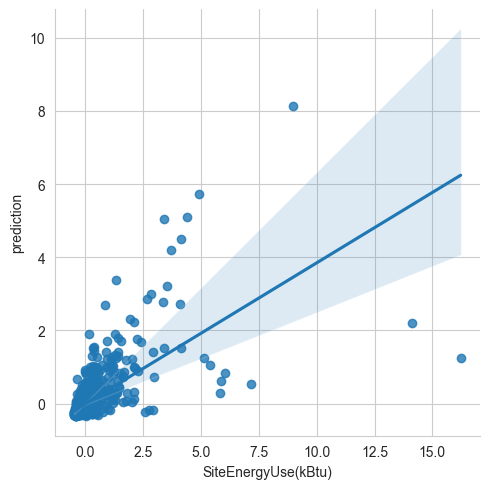

In [1210]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [1241]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.530643,0.530643
years,0.000000,0.000000
NumberofFloors,0.000000,0.000000
NumberofBuildings,0.000000,0.000000
SecondLargestPropertyUseTypeGFA,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
tx_gaz,0.000000,0.000000
BulType,0.000000,0.000000
PPT,0.000000,0.000000
Zip,-0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

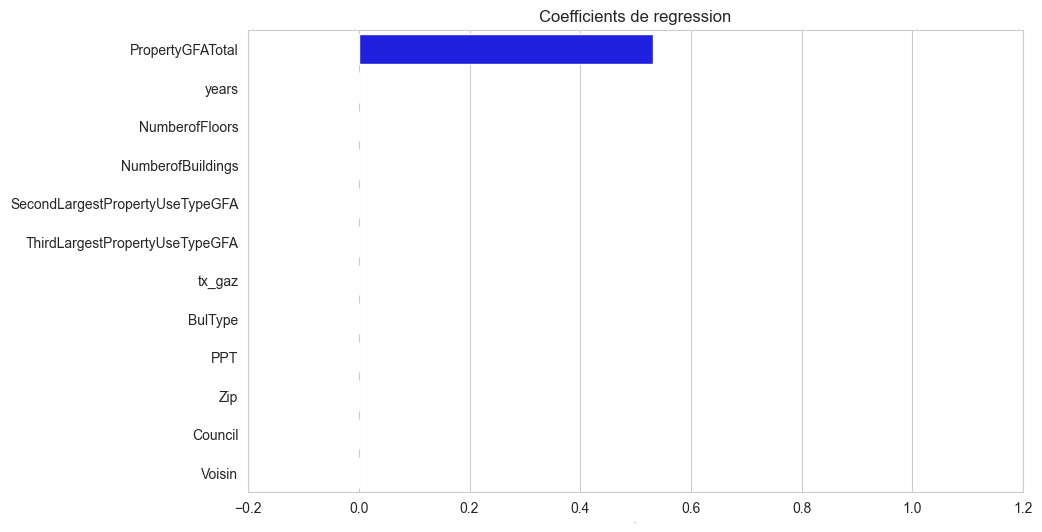

In [1242]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## Regression sur les 5 premieres composantes principales

In [1248]:
from sklearn.decomposition import PCA

In [1311]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.3199672594057478, 0.3387424397430683, 0.3542293398521894, 0.3840063764025131, 0.3820468736908931, 0.3821621410394578, 0.3818022230826398, 0.3792669959287355, 0.3843425337783799, 0.3876462416526345, 0.37151444251718635] 
 [0.2360686124718208, 0.3654043362183711, 0.4823223369998435, 0.5702241957949133, 0.6505096089301706, 0.721634250065609, 0.7855594069927685, 0.8484555645767328, 0.9011832426796902, 0.9490891488271817, 0.9834221203456718]


In [1292]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=2)

In [1293]:
pca.explained_variance_ratio_.sum()

0.36540433621837054

In [1294]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [1295]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print(temps_cr)

0.0


In [1296]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.44066252184436416 
 R2 sur le set de test:  0.33874243974306806


In [1266]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8586517200893266


In [1268]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.262080,-0.335137,-0.162997,-0.099083
1,-0.378923,-0.395949,-0.314892,-0.064032
2,-0.290184,-0.116606,-0.049770,-0.240414
3,-0.326466,-0.243314,-0.101130,-0.225336
4,-0.318230,-0.222707,-0.139521,-0.178708
...,...,...,...,...
999,-0.287444,-0.465311,-0.216902,-0.070542
1000,-0.340326,-0.267006,-0.222448,-0.117878
1001,0.003977,0.174117,0.157781,-0.153804
1002,-0.411427,-0.474359,-0.422193,0.010766


<Figure size 300x300 with 0 Axes>

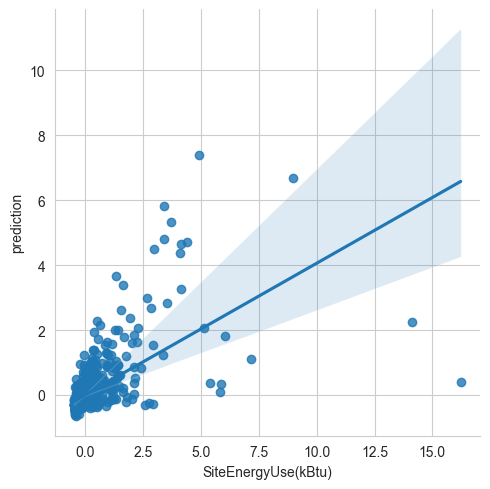

In [1269]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [1272]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3","comp_4","comp_5"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.367508,0.367508
comp_4,0.215741,0.215741
comp_2,0.128193,0.128193
comp_3,0.111339,0.111339
comp_5,0.026408,0.026408


Text(0.5, 1.0, 'Coefficients de regression')

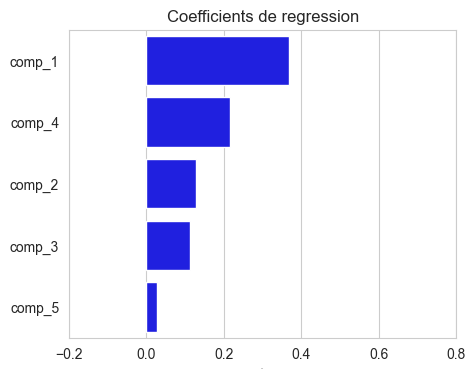

In [1275]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

In [1276]:
len(df_float.columns)

12

# Régression sur le log des données

In [1166]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float_log = df_au_log(df_float)

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_17560\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_17560\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1


In [1167]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print(temps_log)

0.0


### Le modèle est il capable de produire de bonne prédiction ?

In [1168]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6552709976952684 
 R2 sur le set de test:  0.6447087901321698


In [1175]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6858437708113877


In [1176]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,14.578931,10.651099,14.644881,-0.065949
1,13.814143,10.417747,14.108561,-0.294417
2,14.441305,11.209520,14.810168,-0.368863
3,14.229982,10.924373,14.903422,-0.673440
4,14.282022,10.976645,14.742293,-0.460271
...,...,...,...,...
999,14.455587,10.061388,13.666449,0.789138
1000,14.135795,10.860690,14.470069,-0.334274
1001,15.375191,11.660112,15.497101,-0.121911
1002,13.429209,10.003921,13.546839,-0.117629


<Figure size 300x300 with 0 Axes>

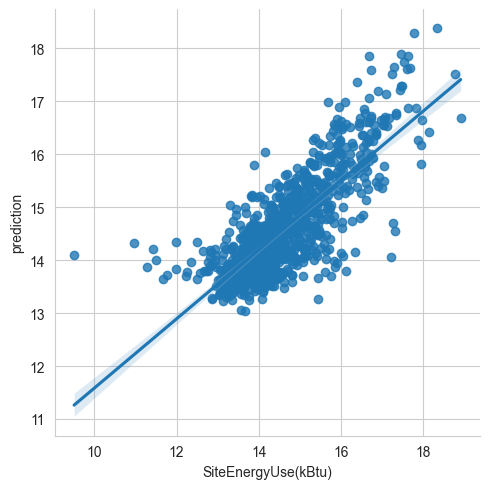

In [1177]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [1178]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_log)
coef

,coeff,coeff_sort
PropertyGFATotal,1.033930,1.033930
BulType,0.290319,0.290319
NumberofBuildings,0.261852,0.261852
Zip,-0.095296,0.095296
years,0.060280,0.060280
tx_gaz,-0.053118,0.053118
Council,0.047161,0.047161
Voisin,-0.035008,0.035008
NumberofFloors,-0.034014,0.034014
PPT,-0.017529,0.017529


Text(0.5, 1.0, 'Coefficients de regression')

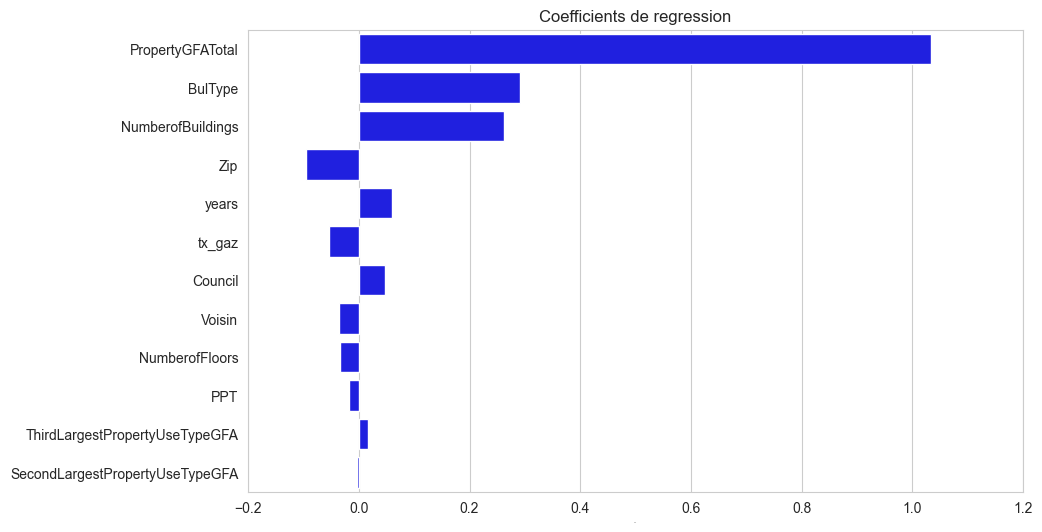

In [1180]:
# Représentation graphique des coefficients
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## Gradient Boosting Regressor sur données en log

In [ ]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [ ]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print(temps_gbr)

In [ ]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

In [ ]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

In [ ]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

In [ ]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

In [ ]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

In [ ]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

In [ ]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [ ]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(gbr.feature_importances_,df_float.columns)
coef

In [ ]:
# Représentation graphique des coefficients
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## XGBoost sur données en log

In [ ]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [ ]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print(temps_gbr)

In [ ]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

In [ ]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

In [ ]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

In [ ]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

In [ ]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [ ]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

In [ ]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

In [ ]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

## Régression XGBoost avec la variable ENERGYSTARScore

In [ ]:
# On inclut la variable ENERGYscore ds le modèle
df_float["ENERGYSTARScore"]=df["ENERGYSTARScore"]
df_float_log = df_au_log(df_float)

In [ ]:
df_float_log

In [ ]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [ ]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print(temps_xgb)

In [ ]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

In [ ]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

In [ ]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

In [ ]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [ ]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

In [ ]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

In [ ]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

In [ ]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)